In [1]:
import sys
sys.path.append("..")

%load_ext autoreload
%autoreload 1
%aimport pygenesig.validation
%aimport pygenesig.gini
%aimport pygenesig.bioqc
%aimport pygenesig.perfmeasures
%matplotlib inline

from pygenesig.validation import * 
from pygenesig.gini import * 
from pygenesig.bioqc import * 
import pygenesig.perfmeasures as pm
import numpy as np
import pandas as pd
from IPython.display import display

import seaborn as sns
from pylab import * 

# Validate Signatures generated on GTEx on mouse samples. 
Here, we demonstrate that the signatures are not transferable to another species (human $\to$ mouse) but also work on different platforms (NGS $\to$ Microarray)

## Load a dataset
Expression Matrix + Tissue Labels for mouse and human

In [16]:
expr = np.load("../data/gtex/exprs.npy")
target = np.genfromtxt("../data/gtex/target.csv", delimiter=",", dtype=str)
gene_symbols = pd.read_csv("../data/gtex/gene_symbols.csv", delimiter=",", dtype=str, header=None)
gene_symbols.columns = ['ensemble', 'hgnc']

In [17]:
human_to_mouse = pd.read_csv("../data/mouseGNF/map_orthologoues.tsv", delimiter="\t")
human_to_mouse['rowname'] = human_to_mouse.index
mouse_expr = pd.read_csv("../data/mouseGNF/mouseGNF-signalMatrix.gct", delimiter="\t", skiprows=2)
mouse_pdata = pd.read_csv("../data/mouseGNF/mouseGNF-phenoData.txt", delimiter="\t")

In [18]:
mouse_target = mouse_pdata.loc[~mouse_pdata["GEO.source.name"].isnull(), "GEO.source.name"].apply(
    lambda x: "_".join(x.split("_")[:-1]))

In [19]:
mouse_expr = mouse_expr.iloc[:, 2:]  # remove description and id
mouse_expr = mouse_expr.values

In [20]:
mouse_expr = mouse_expr[:, mouse_target.index] # select samples with tissue annotation. 
mouse_target = np.array(mouse_target)

### Translation of signatures
The signatures consist of the row indices of the expression matrix they were generated on. 
We therefore need to translate the signatures from the human dataset to the mouse dataset. 

This is done in the following way: 

* GTEx indices -> human gene symbols -> mouse orthologous gene symbols -> mouseGNF indices

In [21]:
translation_df = pd.merge(gene_symbols, human_to_mouse, how='inner', left_on='hgnc', right_on='GeneSymbol')
translation_df.set_index('hgnc', inplace=True)

In [22]:
def translate_signatures(signatures_origin):
    st = {}
    gene_symbol_list = list(gene_symbols.hgnc)
    for tissue, genes in signatures_origin.items():
        st[tissue] = []
        for g in genes:
            gene_symbol = gene_symbol_list[g]
            try: 
                rownames = pd.Series(translation_df.loc[gene_symbol, "rowname"])
                st[tissue].extend(list(rownames))
            except KeyError:
                pass
    return st    

In [23]:
have_orthologue = unique(pd.merge(gene_symbols, translation_df, left_on='hgnc', right_index=True).index)

## Make Signatures

In [26]:
sg = GiniSignatureGenerator(expr[:, :], target)

In [27]:
signatures = sg.mk_signatures(np.array(list(range(len(target)))))

In [28]:
signatures_mouse = translate_signatures(signatures)

## Test Signatures

In [33]:
st = BioQCSignatureTester(mouse_expr, mouse_target)

In [35]:
actual, predicted = st.test_signatures(signatures_mouse, np.array(list(range(len(mouse_target)))), return_labels=True)

In [38]:
result = pd.DataFrame({"actual" : actual, "predicted" : predicted})

In [40]:
confmat = pd.crosstab(result.actual, result.predicted)

In [42]:
sig_labels = st.sort_signatures(signatures)

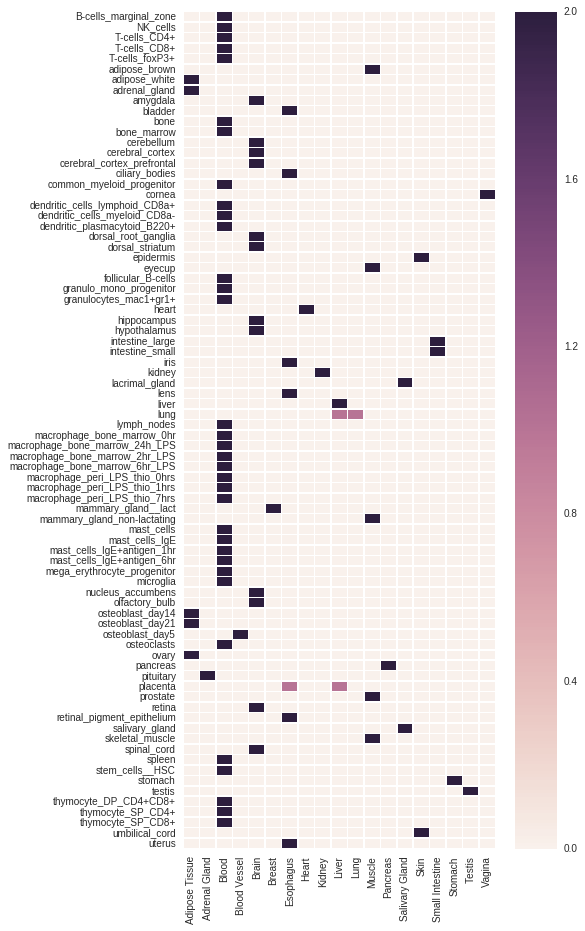

In [46]:
fig, ax = subplots(figsize=(7, 15))
sns.heatmap(confmat.as_matrix(), ax=ax, linewidths=.5, xticklabels=list(confmat.columns), yticklabels=list(confmat.index))
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);